# Welcome to the OnSSET Notebook

This Jupyter based interface is built on the [OnSSET](http://www.onsset.org/) tool developed to provide an easy and quick way to generate electrification investment scenarios.

#### Start by importing the code 

In [1]:
from onsset import *
from IPython.display import display, Markdown, HTML
%matplotlib inline
%run funcs.ipynb
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pylab as plt
import seaborn as sns

# 1. GIS data selection

First, run the cell below to browse to the directory your input CSV file is located at and select the input file. 

In [3]:
import tkinter as tk
from tkinter import filedialog, messagebox
root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)
messagebox.showinfo('OnSSET', 'Open the input file with extracted GIS data')
input_file = filedialog.askopenfilename()

onsseter = SettlementProcessor(input_file)
onsseter.conditioning()

Admin_1 contains null values. Check the input file!


In [4]:
messagebox.showinfo('OnSSET', 'Open the file with hourly PV data')
pv_path = filedialog.askopenfilename()

In [5]:
messagebox.showinfo('OnSSET', 'Open the existing MV lines')
existing_mv = filedialog.askopenfilename()
x_mv_exist, y_mv_exist = onsseter.start_extension_points(existing_mv)

In [6]:
messagebox.showinfo('OnSSET', 'Open the planned MV lines')
planned_mv = filedialog.askopenfilename()
if planned_mv == '':
    x_mv_plan = []
    y_mv_plan = []
else:
    x_mv_plan, y_mv_plan = onsseter.start_extension_points(existing_mv)
planned_coords = []
for i in zip(x_mv_plan, y_mv_plan):
    planned_coords.append(i)
exist_coords = []
for j in zip(x_mv_exist, y_mv_exist):
    exist_coords.append(j)
diff = [x for x in planned_coords if x not in exist_coords]
x_coordinates = x_mv_exist
y_coordinates = y_mv_exist
for i in diff:
    x_coordinates = np.append(x_coordinates, diff[0])      
    y_coordinates = np.append(y_coordinates, diff[1]) 

# 2. Modelling period and target electrification rate

Next, define the modelling period and the electrification rate to be achieved by the end of the analysis. Further down you will also define an intermediate year and target.

In [7]:
start_year = 2023
intermediate_year = 2027
end_year = 2030

intermediate_electrification_rate_target = 0.80 # E.g. 1 for 100% electrification rate or 0.80 for 80% electrification rate
end_electrification_rate_target = 1 # E.g. 1 for 100% electrification rate or 0.80 for 80% electrification rate 

yearsofanalysis = [intermediate_year, end_year]
eleclimits = {intermediate_year: intermediate_electrification_rate_target, end_year: end_electrification_rate_target}
time_steps = {intermediate_year: intermediate_year-start_year, end_year: end_year-intermediate_year}

# 3. Enter country specific data

In addition to the options above the user can customize a large number of variables describing the social - economic - technological environment in the selected country. 

**Note!** Most input values shall represent estimates for the variable valid throughout the modelling period, i.e. **NOT** current values.

### a. Demographics and Social components

In [8]:
pop_start_year = 33000000       ### Write the population in the base year (e.g. 2020) 
end_year_pop = 38000000         ### Write the expected population in the end year (e.g. 2030) 

urban_ratio_start_year = 0.34 ### Write the urban population population ratio in the base year (e.g. 2020)
urban_ratio_end_year = 0.34     ### Write the urban population population ratio in the end year (e.g. 2030)

grid_elec_ratio_start_year = 0.42   ### Write the grid electrification rate in the base year (e.g. 2020)
grid_urban_elec_ratio = 0.53      ### Write urban grid electrification rate in the base year (e.g. 2020)
grid_rural_elec_ratio = 0.06         ### Write rural grid electrification rate in the base year (e.g. 2020)

In [9]:
# Write the number of people per household per province
hh_size = {
    'CABO DELGADO': 4.5,
    'ZAMBEZIA': 4.6,
    'SOFALA': 4.9,
    'INHAMBANE': 4.1, 
    'TETE': 4.5,
    'NAMPULA': 4.6,
    'NIASSA': 4.9,
    'GAZA': 4.6,
    'MANICA': 4.9,
    'MAPUTO': 4.3,
    'National': 4.6
}

In [10]:
# Write the number of households connected to the grid (EDM) in the start year
grid_elec_hhs = {
    'CABO DELGADO': 156832,
    'ZAMBEZIA':  287250,
    'SOFALA':  306626,
    'INHAMBANE':  135603, 
    'TETE':  183061,
    'NAMPULA':  547892,
    'NIASSA':  208109,
    'GAZA':  242323,
    'MANICA':  182550,
    'MAPUTO':  821018,
}

### b. Technology specifications & costs

The cell below contains all the information that is used to calculate the levelized costs for all the technologies, including grid. These default values should be updated to reflect the most accurate values in the country. There are currently 6 potential technologies to include in the model:
 * Grid
 * 
PV Hybrid Mini-grid
 * Wind Mini-grid
 * Hydro Mini-grid
 * PV Stand-alone systems
 * Diesel stand-alone systems

#### Centralized grid parameters 

In [11]:
grid_generation_cost = 0.10                ### This is the grid cost electricity USD/kWh as expected in the end year of the analysis
grid_power_plants_capital_cost = 2000      ### The cost in USD/kW is for capacity upgrades of the grid
grid_losses = 0.40                         ### The fraction of electricity lost in transmission and distribution (percentage)  

annual_new_grid_connections_limit = 9999999 # This is the maximum amount of new households that can be connected to the grid in one year
annual_grid_cap_gen_limit = 9999999        # This is the maximum generation capacity (MW) that can be added to the grid in one year

#### Off-grid technology parameters

In [12]:
min_mg_size = 500             # Minimum number of connections (people) for mini-grids to be considered

# Decide whether mini-grids should be allowed to be interconnected to the grid in a later time-step.
mg_interconnection = 0         # 0 = NO, 1 = YES

In [13]:
diesel_price = 2                    ### This is the diesel price in USD/liter as expected in the end year of the analysis

mg_diesel_cost = {'diesel_price': diesel_price,
                  'efficiency': 0.33,
                  'diesel_truck_consumption': 33.7,
                  'diesel_truck_volume': 15000}

In [14]:
mg_hydro_capital_cost = {float("inf"): 3000}      ### Mini-grid Hydro capital cost (USD/kW) as expected in the years of the analysis
mg_wind_capital_cost = {float("inf"): 3750}                   # Wind turbine capital cost, USD/kW peak power

In [15]:
# PV and hybrid mini-grid costs
pv_cost = 700                      # PV panel costs including BoS (PV inverter, charge controller) (USD/kW)
battery_cost = 200                 # battery capital cost, USD/kWh of storage capacity                    
inverter_cost  = 175             # Battery inverter, USD/kW
diesel_gen_cost = 465              # diesel generator capital cost, USD/kW rated power

max_diesel = 0.5                   # Maximum share of generation that can come from diesel generators (0-1). Set to 0 for fully renewable mini-grids

In [16]:
sa_pv_capital_cost_1 = 9620          ### Stand-alone PV capital cost (USD/kW) for household systems under 20 W
sa_pv_capital_cost_2 = 8780          ### Stand-alone PV capital cost (USD/kW) for household systems between 21-50 W
sa_pv_capital_cost_3 = 6380           ### Stand-alone PV capital cost (USD/kW) for household systems between 51-100 W
sa_pv_capital_cost_4 = 4470           ### Stand-alone PV capital cost (USD/kW) for household systems between 101-1000 W
sa_pv_capital_cost_5 = 4500           ### Stand-alone PV capital cost (USD/kW) for household systems over 1 kW

The cells below contain additional technology specifications

In [17]:
grid_discount_rate = 0.08 # E.g. 0.08 means a discount rate of 8%
mini_grid_discount_rate = 0.12
standalone_discount_rate = 0.15

existing_grid_cost_ratio = 0.1        ### The additional cost per round of electrification (percentage) 

# Transmission and distribution costs
hv_line_capacity=132 # kV
hv_line_cost=53000 # USD/km

mv_line_capacity=33 # kV
mv_line_cost = 26000 # USD/kW
mv_line_max_length=50 # km
mv_line_amperage_limit = 8  # Ampere (A)

lv_line_capacity=0.24 #kV
lv_line_max_length=0.5 # km
lv_line_cost=4250 # USD/km

service_transformer_type=50  # kVA (MV/LV)
service_transformer_cost=4250  # $/unit
max_nodes_per_serv_trans=300  # maximum number of nodes served by each service (MV/LV) transformer

hv_mv_transformer_type = 10000 #kVA
hv_mv_transformer_cost = 150000 # USD/unit

# Centralized grid costs
grid_calc = Technology(om_of_td_lines=0.02,
                        distribution_losses=grid_losses,
                        connection_cost_per_hh=60,
                        base_to_peak_load_ratio=0.8,
                        capacity_factor=1,
                        tech_life=30,
                        grid_penalty_ratio=1,
                        grid_capacity_investment=grid_power_plants_capital_cost,
                        grid_price=grid_generation_cost,
                        discount_rate=grid_discount_rate)

mg_pv_hybrid_calc = Technology(om_of_td_lines=0.02, 
                               distribution_losses=0.05, 
                               connection_cost_per_hh=100, 
                               capacity_factor=0.5, 
                               base_to_peak_load_ratio=0.85,
                               tech_life=20, 
                               mini_grid=True,  
                               hybrid=True, 
                               discount_rate=mini_grid_discount_rate)

mg_wind_calc = Technology(om_of_td_lines=0.02,
                          distribution_losses=0.05,
                          connection_cost_per_hh=100,
                          base_to_peak_load_ratio=0.85,
                          capital_cost=mg_wind_capital_cost,
                          om_costs=0.02,
                          tech_life=20,
                          mini_grid=True,
                          discount_rate=mini_grid_discount_rate)

# Mini-grid hydro costs
mg_hydro_calc = Technology(om_of_td_lines=0.02,
                            distribution_losses=0.05,
                            connection_cost_per_hh=100,
                            base_to_peak_load_ratio=0.85,
                            capacity_factor=0.5,
                            tech_life=30,
                            capital_cost=mg_hydro_capital_cost,
                            om_costs=0.02,
                            discount_rate=mini_grid_discount_rate)
                            

# Stand-alone PV costs
sa_pv_calc = Technology(base_to_peak_load_ratio=0.9,
                        tech_life=15,
                        om_costs=0.05,
                        capital_cost={0.020: sa_pv_capital_cost_1, 
                                      0.050: sa_pv_capital_cost_2, 
                                      0.100: sa_pv_capital_cost_3, 
                                      1: sa_pv_capital_cost_4, 
                                      float("inf"): sa_pv_capital_cost_5},
                        standalone=True,
                        discount_rate=standalone_discount_rate)

mg_pv_hybrid_params = {
                'min_mg_size_ppl': min_mg_size,  # minimum number of people in settlement for mini-grids to be considered as an option
                'diesel_cost': diesel_gen_cost,  # diesel generator capital cost, USD/kW rated power
                'discount_rate': mini_grid_discount_rate,
                'n_chg': 0.93,  # charge efficiency of battery
                'n_dis': 1,  # discharge efficiency of battery
                'battery_cost': battery_cost,  # battery capital cost, USD/kWh of storage capacity
                'pv_cost': pv_cost,  # PV panel capital cost, USD/kW peak power
                'charge_controller': 0,  # PV charge controller cost, USD/kW peak power, set to 0 if already included in pv_cost
                'pv_inverter': 0,  # PV inverter cost, USD/kW peak power, set to 0 if already included in pv_cost
                'pv_life': 25,  # PV panel expected lifetime, years
                'diesel_life': 10,  # diesel generator expected lifetime, years
                'pv_om': 0.015,  # annual OM cost of PV panels
                'diesel_om': 0.1,  # annual OM cost of diesel generator
                'battery_inverter_cost': inverter_cost,
                'battery_inverter_life': 20,
                'dod_max': 0.8,  # maximum depth of discharge of battery
                'inv_eff': 0.93,  # inverter_efficiency
                'lpsp_max': 0.02,  # maximum loss of load allowed over the year, in share of kWh
                'diesel_limit': max_diesel,  # Max annual share of mini-grid generation from diesel gen-set
                'full_life_cycles': 2500  # Equivalent full life-cycles of battery until replacement
            }

### c. Electricity demand target

For the second lever, enter the target tier (level of electricity access) for urban and rural households respectively. This can take a value between "1" (lowest level of electricity access) and "5" (highest level of electricity access) as in ESMAPs Multi-Tier Framework for Measuring Electricity Access (found <a href="https://www.esmap.org/node/55526" target="_blank">here</a>). Alternatively, enter "6" to use a distribution of the tiers across the country based on poverty levels and GDP according to the methodology found <a href="https://www.mdpi.com/1996-1073/12/7/1395" target="_blank">here</a>.   

*On the GEP Explorer, the following three electricity demand targets are used:*

*Top down demand target - Low: In this case, all urban clusters are tergeted to reach the current average consumption level of electrified households, and rural settlements are assigned Tier 1.* 

*Top down demand target - High: In this case, all urban clusters are tergeted to reach one Tier higher than the current average consumption level of electrified households, and rural settlements are assigned Tier 3.*

*Bottom up demand target (Poverty - GDP): In this case each settlement is assigned a demand target based on poverty and GDP levels as described in the methodology above. Choose "6" for both the urban_target_tier and rural_target_tier to use this option* 

In [18]:
# Define the annual household electricity targets to choose from
tier_1 = 38.7  # 38.7 refers to kWh/household/year. 
tier_2 = 219
tier_3 = 803
tier_4 = 2117
tier_5 = 3000

In [19]:
urban_target_tier = 4
rural_target_tier = 2

In [20]:
productive_demand = 1                     # 1 if productive demand is defined and should be included, else 0

### d. Rollout plan
This lever reflects the electrification approach to be examined. On the GEP Explorer, there are currently two options in use:

**Nationwide Least Cost approach:** This options aims to achieve the electrification rate targets set for the intermediate and end year. For the years where the target is set below 100%, the algorithm prioritizes grid densification first (ramp up in already electrified clusters) then selection based on lowest invetsment cost per capita to choose which clusters to be electrified.

**Forced grid approach:** Forced grid under a defined buffer zone (auto_intensification set equal to X km) & least cost approach outside of the buffer zone.

In [21]:
auto_intensification = 5        # Buffer distance (km) for automatic intensification

max_grid_intensification_cost = 2000  # Maximum cost per household (USD/household) for forced grid intensification 

# 4. Calibration of start year values and general information

The following steps calibrate the start year conditions in the country in terms of population and current electrification rate, and also adds some additional useful information to be used in the further calculations. If you have retrieved the input file from Energydata.info some of these steps are already completed, and you may skip those cells below where there is a note. 

In [56]:
regions = onsseter.df.Admin_1.unique().tolist()
onsseter.df[SET_NUM_PEOPLE_PER_HH] = hh_size['National']

pop_modelled, urban_modelled = onsseter.calibrate_current_pop_and_urban(pop_start_year, urban_ratio_start_year)
onsseter.project_pop_and_urban(end_year_pop, urban_ratio_end_year, start_year, yearsofanalysis)
onsseter.df[SET_WINDCF] = onsseter.calc_wind_cfs(onsseter.df[SET_WINDVEL])

for region in regions:
    try:
        hhs = onsseter.df.loc[(onsseter.df['Admin_1'] == region), 'Pop' + "{}".format(start_year)].sum() / hh_size[region]
        onsseter.df.loc[(onsseter.df['Admin_1'] == region), SET_NUM_PEOPLE_PER_HH] = hh_size[region]
        print(region, 'Estimated number of households: ', round(hhs))
    except:
        pass

display(Markdown('#### The csv file has been imported correctly. Here is a preview:'))
display(onsseter.df[['Country','Pop', 'GridCellArea', 'NightLights', 'TravelHours', 'GHI', 'WindVel', 'CurrentMVLineDist']].sample(7))

GAZA Estimated number of households:  329968.0
TETE Estimated number of households:  719690.0
MAPUTO Estimated number of households:  865927.0
MANICA Estimated number of households:  465450.0
INHAMBANE Estimated number of households:  374255.0
SOFALA Estimated number of households:  547911.0
NIASSA Estimated number of households:  458525.0
ZAMBEZIA Estimated number of households:  1324097.0
NAMPULA Estimated number of households:  1490748.0
CABO DELGADO Estimated number of households:  627461.0


#### The csv file has been imported correctly. Here is a preview:

,Country,Pop,GridCellArea,NightLights,TravelHours,GHI,WindVel,CurrentMVLineDist
576105,Mozambique,11.873,0.018,0.339394,9.016667,2002.0,3.214406,8.771564
302368,Mozambique,5.088,0.009,0.313885,6.800000,1917.0,2.336051,11.901425
593726,Mozambique,6.552,0.018,0.322044,3.483333,1994.0,2.871815,27.616792
347276,Mozambique,18.765,0.018,0.341518,2.166667,2035.0,2.906783,27.448740
619421,Mozambique,9.972,0.020,0.285969,3.016667,2006.0,1.873683,8.077587
204062,Mozambique,6.357,0.009,0.300013,5.716667,2012.0,3.156665,5.980682
319274,Mozambique,4.246,0.009,0.316797,6.283333,1931.0,3.028934,2.369931


#### Calibration of currently grid-electrified settlements

The model calibrates which settlements are likely to be electrified in the start year, to match the national statistical values defined above. A settlement is considered to be electrified if it meets all of the following conditions:
- Has more night-time lights than the defined threshold (this is set to 0 by default. Set to -1 to disregard NTL completely)
- Is closer to the existing grid network than the distance limit
- Has more population than the threshold

First, define the threshold limits. Then run the calibration and check if the results seem okay. Else, redefine these thresholds and run again.

In [51]:
min_night_lights = 0.35    ### 0 Indicates no night light, while any number above refers to the night-lights intensity
min_pop = 250      ### Settlement population above which we can assume that it could be electrified
max_mv_line_distance = 1.5 ### Distance  in km from the existing grid network below which we can assume a settlement could be electrified

onsseter.df['ElecPop'] = 0
onsseter.df[SET_ELEC_FINAL_CODE + "{}".format(start_year)] = 99
onsseter.df[SET_ELEC_POP_CALIB] = 0
onsseter.df[SET_ELEC_CURRENT] = 0
onsseter.df[SET_ELEC_POP + "{}".format(start_year)] = 0

for region in regions:
    try:
        onsseter.df['ElecTemp'] = 0
        onsseter.df.loc[(onsseter.df['Admin_1'] == region) & (onsseter.df['ConfirmedElectrified'] == 1), 'ElecTemp'] = 1
        
        onsseter.df.loc[(onsseter.df['Admin_1'] == region) & (onsseter.df['CurrentMVLineDist'] < max_mv_line_distance) & (onsseter.df['NightLights'] > min_night_lights) & (onsseter.df['Pop'] > min_pop), 'ElecTemp'] = 1
        elec_pop = onsseter.df.loc[onsseter.df['ElecTemp'] == 1, 'Pop'].sum()
        
        elec_hh_est = elec_pop / hh_size[region]

        if elec_hh_est > grid_elec_hhs[region]:
            factor = grid_elec_hhs[region] / elec_hh_est
            onsseter.df.loc[onsseter.df['ElecTemp'] == 1, 'ElecPop'] = onsseter.df['Pop'] * factor 
            print(region, 'Estimated electrified households: ', round(elec_hh_est))
        else:
            i = 0
            ntl = min_night_lights + 0.01
            pop = min_pop + 50
            while (i < 4) & (elec_hh_est < grid_elec_hhs[region]):
                onsseter.df['ElecTemp'] = 0
                onsseter.df.loc[(onsseter.df['Admin_1'] == region) & (onsseter.df['ConfirmedElectrified'] == 1), 'ElecTemp'] = 1
                #ntl -= 0.01
                pop -= 50
                onsseter.df.loc[(onsseter.df['Admin_1'] == region) & (onsseter.df['CurrentMVLineDist'] < max_mv_line_distance) & (onsseter.df['NightLights'] > ntl) & (onsseter.df['Pop'] > pop), 'ElecTemp'] = 1
                
                elec_pop = onsseter.df.loc[(onsseter.df['ElecTemp'] == 1), 'Pop'].sum()
                elec_hh_est = elec_pop / hh_size[region]
                i += 1
            onsseter.df.loc[onsseter.df['ElecTemp'] == 1, 'ElecPop'] = onsseter.df['Pop']
            print(region, 'Estimated electrified households: ', round(elec_hh_est))
    except:
        pass
onsseter.df['ElecHHS'] = onsseter.df['ElecPop'] / onsseter.df['HH_Size']

onsseter.df.loc[onsseter.df['ElecPop'] > 0, SET_ELEC_CURRENT] = 1
onsseter.df.loc[onsseter.df['ElecPop'] > 0, SET_ELEC_POP_CALIB] = onsseter.df['ElecPop'] 
onsseter.df.loc[onsseter.df['ElecPop'] > 0, SET_ELEC_FINAL_CODE + "{}".format(start_year)] = 1 
onsseter.df.loc[onsseter.df['ElecPop'] > 0, SET_ELEC_POP + "{}".format(start_year)] = onsseter.df['ElecPop'] 

GAZA Estimated electrified households:  223278.0
TETE Estimated electrified households:  350778.0
MAPUTO Estimated electrified households:  762476.0
MANICA Estimated electrified households:  273762.0
INHAMBANE Estimated electrified households:  169271.0
SOFALA Estimated electrified households:  363194.0
NIASSA Estimated electrified households:  208096.0
ZAMBEZIA Estimated electrified households:  452920.0
NAMPULA Estimated electrified households:  720180.0
CABO DELGADO Estimated electrified households:  382594.0


In [52]:
mg_dist = 1   # Distance from existing mini-grids to consider settlements connected to the mini-grid
mg_ntl = 0   # Night-time light threshold to consider a settlement mini-grid electrified, in combination with mg_dist. 0 means NTL is not required, any higher value means a higher cut-off for settlements with NTL within dist is electrified

onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)] == 5, 'ElecStart'] = 0
onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)] == 5, 'FinalElecCode' + '{}'.format(start_year)] = 99
onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)] == 5, 'ElecPopCalib'] = 0
onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)] == 5, 'ElecPop' + '{}'.format(start_year)] = 0

onsseter.df.loc[(onsseter.df['FinalElecCode' + '{}'.format(start_year)] != 1) & (onsseter.df['NightLights'] >= mg_ntl) & 
                (onsseter.df['MGDist'] < mg_dist), 'ElecStart'] = 1
onsseter.df.loc[(onsseter.df['FinalElecCode' + '{}'.format(start_year)] != 1) & (onsseter.df['NightLights'] >= mg_ntl) & 
                (onsseter.df['MGDist'] < mg_dist), 'FinalElecCode' + '{}'.format(start_year)] = 5
onsseter.df.loc[(onsseter.df['FinalElecCode' + '{}'.format(start_year)] != 1) & (onsseter.df['NightLights'] >= mg_ntl) & 
                (onsseter.df['MGDist'] < mg_dist), 'ElecPopCalib'] = onsseter.df['PopStartYear']
onsseter.df['ElecPop' + '{}'.format(start_year)] = onsseter.df['ElecPopCalib']

mg_pop = onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)] == 5, 'PopStartYear'].sum() / onsseter.df['PopStartYear'].sum()

pop_sum = onsseter.df['PopStartYear'].sum()
elec_pop_sum = onsseter.df[SET_ELEC_POP_CALIB].sum()

print('The modelled grid + mini-grid electrification rate is: ', round(elec_pop_sum/pop_sum, 3))

The modelled grid + mini-grid electrification rate is:  0.414


#### Visualization

The figure below show the results of the calibration. Settlements in **blue** are considered to be (at least partly) grid-electrified already in the start year of the analysis, settlements in **purple** are considered to be connected to mini-grids at the start of the analysis, while settlements in **grey** are yet to be electrified. Re-running the calibration step with different intial values may change the map below.

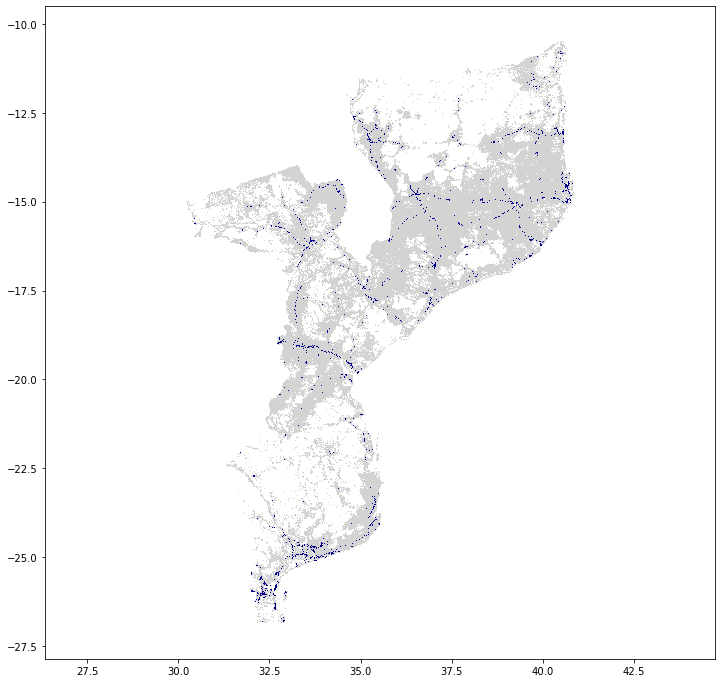

<Figure size 2160x2160 with 0 Axes>

In [53]:
from matplotlib import pyplot as plt
colors = ['#D3D3D3','#808080', 'red']
plt.figure(figsize=(12,12))
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)]==99, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)]==99, SET_Y_DEG], color='#D3D3D3', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)]==1, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)]==1, SET_Y_DEG], color='#00008B', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)]==5, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode' + '{}'.format(start_year)]==5, SET_Y_DEG], color='red', marker=',', linestyle='none')
if onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min() > onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min():
    plt.xlim(onsseter.df[SET_X_DEG].min() - 1, onsseter.df[SET_X_DEG].max() + 1)
    plt.ylim((onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 - 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) - 1, (onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 + 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) + 1)
else:
    plt.xlim((onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 - 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) - 1, (onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 + 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) + 1)
    plt.ylim(onsseter.df[SET_Y_DEG].min() -1, onsseter.df[SET_Y_DEG].max() +1)
plt.figure(figsize=(30,30))
logging.getLogger('matplotlib.font_manager').disabled = True

# 5. Start a scenario run, which calculate and compare technology costs for every settlement in the country

Based on the previous calculation this piece of code identifies the LCoE that every off-grid technology can provide, for each single populated settlement of the selected country. The cell then takes all the currently grid-connected points in the country, and looks at the points within a certain distance from them, to see if it is more economical to connect them to the grid, or to use one of the off-grid technologies calculated above. Once more points are connected to the grid, the process is repeated, so that new points close to those points might also be connected. This is repeated until there are no new points to connect to the grid.

In [ ]:
x_coords = x_coordinates * 1
y_coords = y_coordinates * 1

import time
print('Starting', time.ctime())

techs = ["Grid", "SA_PV", "MG_Diesel", "MG_PVHybrid", "MG_Wind", "MG_Hydro"]
tech_codes = [1, 3, 4, 5, 6, 7]

onsseter.prepare_wtf_tier_columns(tier_1, tier_2, tier_3, tier_4, tier_5)

onsseter.current_mv_line_dist()

onsseter.add_xy_3395()

try:
    onsseter.df.reset_index(inplace=True)
except ValueError:
    pass

Technology.set_default_values(base_year=start_year, start_year=start_year, end_year=end_year,
                             hv_line_type=hv_line_capacity, hv_line_cost=hv_line_cost, mv_line_type=mv_line_capacity,
                             mv_line_amperage_limit=mv_line_amperage_limit, mv_line_cost=mv_line_cost, 
                             lv_line_type=lv_line_capacity, lv_line_cost=lv_line_cost, lv_line_max_length=lv_line_max_length, 
                             service_transf_type=service_transformer_type, service_transf_cost = service_transformer_cost,
                             max_nodes_per_serv_trans=max_nodes_per_serv_trans, hv_mv_sub_station_cost=hv_mv_transformer_cost,
                             hv_mv_substation_type=hv_mv_transformer_type)

new_lines_geojson = {}

for year in yearsofanalysis:
        
    eleclimit = eleclimits[year]
    time_step = time_steps[year]
    
    grid_connect_limit = time_step * annual_new_grid_connections_limit
    grid_cap_gen_limit = time_step * annual_grid_cap_gen_limit * 1000
        
    onsseter.calculate_demand(year, hh_size['National'], hh_size['National'], time_step,
                                            urban_target_tier, rural_target_tier)

    try:
        del onsseter.df[SET_MG_DIESEL_FUEL + "{}".format(year)]
        del onsseter.df[SET_SA_DIESEL_FUEL + "{}".format(year)]
    except:
        pass
    onsseter.diesel_cost_columns(mg_diesel_cost, mg_diesel_cost, year)
    mean = onsseter.df[SET_MG_DIESEL_FUEL + "{}".format(year)].mean()
    onsseter.df[SET_MG_DIESEL_FUEL + "{}".format(year)].fillna(mean, inplace=True)
        
    print('Optimize MG Hybrid Systems', time.ctime())
    hybrid_lcoe, hybrid_capacity, hybrid_investment, check = \
                    onsseter.pv_hybrids_lcoe_lookuptable(year, time_step, end_year, mg_pv_hybrid_params, pv_path=pv_path)
    hybrid_investment.fillna(0, inplace=True)
    hybrid_capacity.fillna(0, inplace=True)

    mg_pv_hybrid_calc.hybrid_fuel = hybrid_lcoe
    mg_pv_hybrid_calc.hybrid_investment=hybrid_investment
    mg_pv_hybrid_calc.hybrid_capacity=hybrid_capacity
    
    print('Calculate Off-Grid LCOEs', time.ctime())
    sa_diesel_investment, sa_diesel_capacity, sa_pv_investment, sa_pv_capacity, mg_diesel_investment, \
            mg_diesel_capacity, mg_pv_hybrid_investment, mg_pv_hybrid_capacity, mg_wind_investment, mg_wind_capacity, \
            mg_hydro_investment, mg_hydro_capacity = onsseter.calculate_off_grid_lcoes(mg_hydro_calc, mg_wind_calc, sa_pv_calc, mg_pv_hybrid_calc,
                                                                                       year, end_year, time_step, techs, tech_codes)
    
    print('Calculate Grid LCOEs', time.ctime())
    grid_investment, grid_capacity, grid_cap_gen_limit, grid_connect_limit = \
                onsseter.pre_electrification(grid_generation_cost, year, time_step, end_year, grid_calc,
                                             grid_cap_gen_limit, grid_connect_limit)
    
    onsseter.max_extension_dist(year, time_step, end_year, start_year, grid_calc, max_grid_intensification_cost)

    onsseter.pre_selection(eleclimit, year, time_step, 2, auto_intensification)

    
    onsseter.df[SET_LCOE_GRID + "{}".format(year)], onsseter.df[SET_MIN_GRID_DIST + "{}".format(year)], \
        grid_investment, grid_capacity, x_coords, y_coords, new_lines_geojson[year] = \
        onsseter.elec_extension_numba(grid_calc, mv_line_max_length, year, start_year, end_year, time_step, grid_cap_gen_limit, grid_connect_limit,
                                      x_coords, y_coords, auto_intensification=auto_intensification, prioritization=2, threshold=max_grid_intensification_cost,
                                      )
    
    print('Calculating results columns', time.ctime())
    onsseter.results_columns(techs, tech_codes, year, time_step, 2, auto_intensification,
                             mg_interconnection)

    onsseter.calculate_investments_and_capacity(sa_diesel_investment, sa_diesel_capacity, sa_pv_investment,
                                                sa_pv_capacity, mg_diesel_investment, mg_diesel_capacity,
                                                mg_pv_hybrid_investment, mg_pv_hybrid_capacity, mg_wind_investment,
                                                mg_wind_capacity, mg_hydro_investment, mg_hydro_capacity,
                                                grid_investment, grid_capacity, year)

    if year == yearsofanalysis[-1]:
        final_step = True
    else:
        final_step = False

    onsseter.check_grid_limitations(time_step * annual_new_grid_connections_limit, 
                                    time_step * annual_grid_cap_gen_limit * 1000, 
                                    year, time_step, final_step)

    onsseter.apply_limitations(eleclimit, year, time_step, 2, auto_intensification)

    onsseter.calculate_emission(grid_factor=0, year=year,
                                time_step=time_step, start_year=start_year)

    onsseter.df.loc[(onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] == 1) &
                        (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(start_year)] != 1),
                        SET_ELEC_FINAL_CODE + '{}'.format(year)] = 2
    print('')
    
finalize_results(onsseter, yearsofanalysis)

Starting Wed Sep 11 09:15:10 2024
Optimize MG Hybrid Systems Wed Sep 11 09:15:13 2024


# 6. Results, Summaries and Visualization
With all the calculations and grid-extensions complete, this block gets the final results on which technology was chosen for each point, how much capacity needs to be installed and what it will cost. Then the summaries, plots and maps are generated.

In [ ]:
summary_table, columns = calc_summary_table(onsseter.df)
display(Markdown('### Summary \n These are the summarized results of the selected country'))
summary_table

In [ ]:
bar_plot(summary_table, columns)

In [ ]:
map_plot(onsseter.df)

## 9. Exporting results

This code generates three csv files:
 - one containing all the results for the scenario created
 - one containing the summary for the scenario created
 - one containing some if the key input variables of the scenario

Before we proceed, please write the scenario_name in the first cell below. then move on to the next cell and run it to browse to the directory where you want to save your results. Sample file shall be located at .\ gep-onsset\sample_output. 

**Note that if you do not change the scenario name, the previous output files will be overwritten**

In [ ]:
scenario_name = "scenario_name"

In [ ]:
list1 = [('Start_year',start_year,'','',''), 
         ('End_year',end_year,'','',''),
         ('End year electrification rate target',end_electrification_rate_target,'','',''),
         ('Intermediate target year', intermediate_year,'','',''),
         ('Intermediate electrification rate target', intermediate_electrification_rate_target,'','',''),
         ('Urban target tier', urban_target_tier, '', '', ''),
         ('Rural target tier', rural_target_tier, '', '', ''),
         ('Auto intensification distance', auto_intensification, '', '', 'Buffer distance (km) for automatic intensification if choosing prioritization 1'),
         ('discount_rate',discount_rate,'','',''),
         ('pop_start_year',pop_start_year,'','','the population in the base year (e.g. 2018)'),
         ('pop_end_year',end_year_pop,'','','the projected population in the end year (e.g. 2030)'),
         ('urban_ratio_start_year',urban_ratio_start_year,'','','the urban population population ratio in the base year (e.g. 2018)'),
         ('urban_ratio_end_year',urban_ratio_end_year,'','','the urban population population ratio in the end year (e.g. 2030)'),
         ('num_people_per_hh_urban',num_people_per_hh_urban,'','','the number of people per household expected in the end year (e.g. 2030)'),
         ('num_people_per_hh_rural',num_people_per_hh_rural,'','','the number of people per household expected in the end year (e.g. 2030)'),
         ('elec_ratio_start_year',grid_elec_ratio_start_year,'','','the electrification rate in the base year (e.g. 2018)'),
         ('urban_elec_ratio',grid_urban_elec_ratio,'','','urban electrification rate in the base year (e.g. 2018)'),
         ('rural_elec_ratio',grid_rural_elec_ratio,'','','rural electrification rate in the base year (e.g. 2018)'),
         ('grid_generation_cost',grid_generation_cost,'','','This is the grid cost electricity USD/kWh as expected in the end year of the analysis'),
         ('grid_power_plants_capital_cost',grid_power_plants_capital_cost,'','','The cost in USD/kW to for capacity upgrades of the grid-connected power plants'),
         ('grid_losses',grid_losses,'','','The fraction of electricity lost in transmission and distribution (percentage)'),
         ('base_to_peak',grid_calc.base_to_peak_load_ratio,'','','The ratio of base grid demand to peak demand (percentage)'),
         ('existing_grid_cost_ratio',existing_grid_cost_ratio,'','','The additional cost per round of electrification (percentage)'),
         ('diesel_price',diesel_price,'','','This is the diesel price in USD/liter as expected in the end year of the analysis'),
         ('mg_hydro_capital_cost',mg_hydro_capital_cost,'','','Mini-grid Hydro capital cost (USD/kW) as expected in the years of the analysis'),
         ('sa_pv_capital_cost_1',sa_pv_capital_cost_1,'','','Stand-alone PV capital cost (USD/kW) for household systems under 20 W'),
         ('sa_pv_capital_cost_2',sa_pv_capital_cost_2,'','','Stand-alone PV capital cost (USD/kW) for household systems between 21-50 W'),
         ('sa_pv_capital_cost_3',sa_pv_capital_cost_3,'','','Stand-alone PV capital cost (USD/kW) for household systems between 51-100 W'),
         ('sa_pv_capital_cost_4',sa_pv_capital_cost_4,'','','Stand-alone PV capital cost (USD/kW) for household systems between 101-200 W'),
         ('sa_pv_capital_cost_5',sa_pv_capital_cost_5,'','','Stand-alone PV capital cost (USD/kW) for household systems over 200 W'),
         ('mv_line_cost',mv_line_cost,'','','Cost of MV lines in USD/km'),
         ('lv_line_cost',lv_line_cost,'','','Cost of LV lines in USD/km'),
         ('mv_line_capacity',mv_line_capacity,'','','Capacity of MV lines in kW/line'),
         ('lv_line_capacity',lv_line_capacity,'','','Capacity of LV lines in kW/line'),
         ('lv_line_max_length',lv_line_max_length,'','','Maximum length of LV lines (km)'),
         ('hv_line_cost',hv_line_cost,'','','Cost of HV lines in USD/km'),
         ('max_grid_extension_dist',mv_line_max_length,'','','Maximum distance that the grid may be extended by means of MV lines'),
         #('annual_new_grid_connections_limit_intermediate', annual_new_grid_connections_limit_intermediate,'','','This is the maximum amount of new households that can be connected to the grid in one year (thousands)'),
         ('annual_new_grid_connections_limit_end', annual_new_grid_connections_limit,'','','This is the maximum amount of new households that can be connected to the grid in one year (thousands)'),
         ('grid_capacity_limit_end',annual_grid_cap_gen_limit,'','','This is the maximum generation capacity that can be added to the grid in one year (MW)'),
         #('grid_capacity_limit_intermediate',annual_grid_cap_gen_limit_intermediate,'','','This is the maximum generation capacity that can be added to the grid in one year (MW)'),
         ]
labels = ['Variable','Value', 'Source', 'Comments', 'Description']
df_variables = pd.DataFrame.from_records(list1, columns=labels)

In [ ]:
messagebox.showinfo('OnSSET', 'Browse to the folder where you want to save the outputs')

output_dir = filedialog.askdirectory()
output_dir_variables = os.path.join(output_dir, '{}_Variables.csv'.format(scenario_name))
output_dir_results = os.path.join(output_dir, '{}_Results.csv'.format(scenario_name))
output_dir_summaries = os.path.join(output_dir, '{}_Summaries.csv'.format(scenario_name))

In [ ]:
# Returning the result as a csv file
onsseter.df.to_csv(output_dir_results, index=False)

# Returning the summary as a csv file
summary_table.to_csv(output_dir_summaries, index=True)

# Returning the input variables as a csv file
df_variables.to_csv(output_dir_variables, index=False)

In [ ]:
for year in yearsofanalysis:
    try:
        with open(os.path.join(output_dir, 'new_mv_lines_{}_{}.geojson'.format(scenario_name, year)), 'w') as f:
            geojson.dump(new_lines_geojson[year], f)
        gdf = gpd.read_file(os.path.join(output_dir, 'new_mv_lines_{}_{}.geojson'.format(scenario_name, year)))
        gdf = gdf.set_crs(3395, allow_override=True)
        gdf = gdf.to_crs(4326)
        gdf.to_file(os.path.join(output_dir, 'new_mv_lines_{}_{}.geojson'.format(scenario_name, year)))
    except:
        pass